# Example for using multiple graph
This notebook demonstrates how to use multiple graph within a LAN.
This experiment utilizes processes as computing nodes.

## 1. Set some global parameters:

In [4]:
if __name__ == "__main__":
    N_STATE = 3
    N_NODES = 5

## 2. Deploy the nodes using multiprocessing:
Here, we use the Laplacian-based consensus iteration formula:
$$
x(k+1) = x(k) - \alpha L x(k).
$$
In this example, we consider two network topologies: **ring** and **star** graphs.

In [5]:
from multiprocessing import Pool
from numpy import float64
from numpy.typing import NDArray


def graph_server() -> None:
    def ring_graph():
        from logging import basicConfig, INFO

        basicConfig(level=INFO)

        from topolink import Graph

        nodes = ["1", "2", "3", "4", "5"]
        edges = [("1", "2"), ("2", "3"), ("3", "4"), ("4", "5"), ("5", "1")]

        graph = Graph(nodes, edges, name="ring")

        graph.deploy()

    def star_graph():
        from logging import basicConfig, INFO

        basicConfig(level=INFO)

        from topolink import Graph

        nodes = ["1", "2", "3", "4", "5"]
        edges = [("1", "2"), ("1", "3"), ("1", "4"), ("1", "5")]

        graph = Graph(nodes, edges, name="star")

        graph.deploy()

    import threading

    ring_thread = threading.Thread(target=ring_graph)
    star_thread = threading.Thread(target=star_graph)

    ring_thread.start()
    star_thread.start()

    ring_thread.join()
    star_thread.join()


def consensus(
    name: str, graph_name: str, n_state: int, alpha: float, n_iter: int = 50
) -> NDArray[float64]:
    from numpy import zeros
    from numpy.random import uniform, seed
    from topolink import NodeHandle

    nh = NodeHandle(name, graph_name)

    states = zeros((n_iter, n_state))
    seed(int(name))  # Ensure reproducibility for each node
    states[0] = uniform(-100.0, 100.0, n_state)

    for k in range(n_iter - 1):
        lap_state = nh.laplacian(states[k])
        states[k + 1] = states[k] - lap_state * alpha

    return states


if __name__ == "__main__":
    with Pool(2 * N_NODES + 1) as pool:
        server = pool.apply_async(graph_server)

        ring_tasks = [
            pool.apply_async(consensus, args=(str(i + 1), "ring", N_STATE, 0.35))
            for i in range(N_NODES)
        ]
        star_tasks = [
            pool.apply_async(consensus, args=(str(i + 1), "star", N_STATE, 0.35))
            for i in range(N_NODES)
        ]

        ring_states = [task.get() for task in ring_tasks]
        star_states = [task.get() for task in star_tasks]

        server.get()

INFO:topolink.graph:Graph 'ring' running on: 158.125.191.62:45791
INFO:topolink.graph:Graph 'star' running on: 158.125.191.62:45357
INFO:topolink.discovery:Registered graph service with name 'ring'
INFO:topolink.graph:Node '4' joined graph 'ring' from 158.125.191.62:46279.
INFO:topolink.graph:Node '5' joined graph 'ring' from 158.125.191.62:44661.
INFO:topolink.graph:Node '2' joined graph 'ring' from 158.125.191.62:46519.
INFO:topolink.graph:Node '1' joined graph 'ring' from 158.125.191.62:46099.
INFO:topolink.graph:Node '3' joined graph 'ring' from 158.125.191.62:44749.
INFO:topolink.graph:Graph 'ring' registration complete.
INFO:topolink.graph:Sent neighbor information to all nodes in graph 'ring'.
INFO:topolink.discovery:Registered graph service with name 'star'
INFO:topolink.graph:Node '1' joined graph 'star' from 158.125.191.62:45691.
INFO:topolink.graph:Node '2' joined graph 'star' from 158.125.191.62:45891.
INFO:topolink.graph:Node '3' joined graph 'star' from 158.125.191.62:458

## 3. Plot the results:

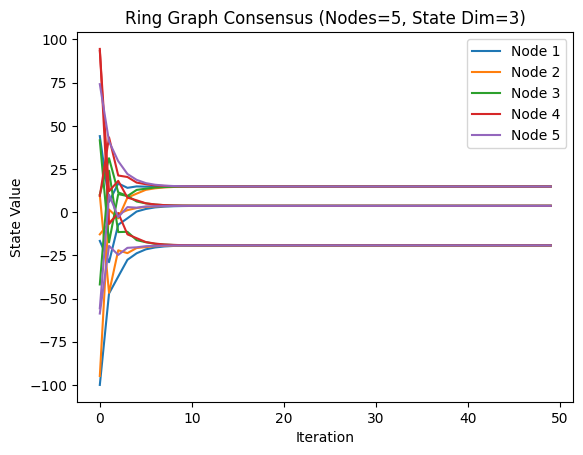

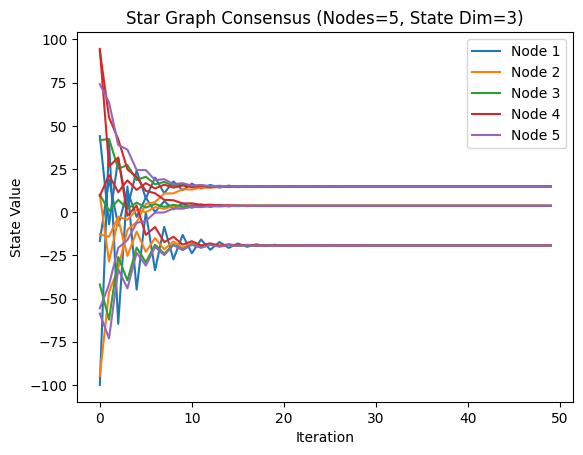

In [6]:
if __name__ == "__main__":
    import matplotlib.pyplot as plt

    colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]

    _, ax1 = plt.subplots()

    for i in range(N_NODES):
        states = ring_states[i]
        for j in range(N_STATE):
            (line,) = ax1.plot(states[:, j], color=colors[i])
            line.set_label(f"Node {i + 1}") if j == 0 else None

    ax1.set_xlabel("Iteration")
    ax1.set_ylabel("State Value")
    ax1.legend()
    ax1.set_title(f"Ring Graph Consensus (Nodes={N_NODES}, State Dim={N_STATE})")

    _, ax2 = plt.subplots()

    for i in range(N_NODES):
        states = star_states[i]
        for j in range(N_STATE):
            (line,) = ax2.plot(states[:, j], color=colors[i])
            line.set_label(f"Node {i + 1}") if j == 0 else None

    ax2.set_xlabel("Iteration")
    ax2.set_ylabel("State Value")
    ax2.legend()
    ax2.set_title(f"Star Graph Consensus (Nodes={N_NODES}, State Dim={N_STATE})")

    plt.show()